In [1]:
# pip install seaborn

# Check List
1. **Importing Libraries:** such as TensorFlow for deep learning, as well as other libraries for data manipulation, visualization, and evaluation.

2. **Data Preprocessing:** Preprocess your dataset to ensure it is in a suitable format for training and evaluation. This may include tasks such as loading and resizing the images, applying normalization or data augmentation techniques, and splitting the dataset into training and validation sets.

3. **Model Definition:** Define the architecture of the deep learning model. use the VGG19 model as a base and modify it by removing or adding layers based on your specific task requirements.

4. **Model Compilation:** Compile the model by specifying the loss function, optimizer, and evaluation metrics to be used during training.

5. **Model Training:** Train your model on the prepared training dataset. Use the appropriate training loop or fit function to iterate over the dataset, update the model's weights, and monitor the training progress.

6. **Model Evaluation:** Evaluate the performance of the trained model on the validation dataset. Calculate metrics such as accuracy, precision, recall, and F1-score to assess the model's classification performance.

7. **Fine-tuning:** Optionally, you can perform fine-tuning by unfreezing some of the layers in the pre-trained VGG19 model and training them along with the newly added layers. This step can help further improve the model's performance on your specific task.

8. **Testing:** Once the model is trained and fine-tuned (if applicable), you can use it to make predictions on unseen test data. Evaluate the model's performance on the test set using appropriate metrics and generate predictions or class probabilities.

9. **Results and Analysis:** Summarize and analyze the results obtained from the model evaluation and testing. Discuss the model's performance, strengths, and limitations, and compare it to other existing models or approaches.

10. **Conclusion and Future Work:** Provide a conclusion on the project, highlighting the achieved outcomes and their significance in the context of lung cancer classification. Discuss potential areas of improvement or future work that could be explored.

//  include necessary code comments, documentation, and visualizations

In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Loading libraries

In [3]:
# import system libs
import os
import time
import shutil
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, SGD, AdamW
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy


print ('modules loaded')

modules loaded


### Defining Hyperparameters

In [4]:
# Data pre-processing
Batch_size = 32
IMAGE_SIZE = (224, 224)
Epochs = 90
Channels = 3  # Number of color channels (RGB)

In [5]:
# this cell executed successfully on 25-06-2023, 2:17 hours # #
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set the path to your directory containing the folders with images
data_dir = PATH

# Set the desired number of augmented images for each original image
augmentation_factor = 5

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

# Loop through each folder in the directory
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)

    # Check if the item in the directory is a folder
    if os.path.isdir(class_path):
        # Generate augmented images for each image in the class folder
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Load the image
            img = load_img(img_path)
            img_array = img_to_array(img)

            # Reshape the image to match the input shape of the model (if needed)

            # Create a directory to store augmented images if it doesn't exist
            aug_class_folder = f"{class_folder}_augmented"
            aug_class_path = os.path.join(data_dir, aug_class_folder)
            os.makedirs(aug_class_path, exist_ok=True)

            # Create the iterator for generating augmented images
            img_generator = datagen.flow(
                img_array.reshape((1,) + img_array.shape),
                batch_size=1,
                save_to_dir=aug_class_path,
                save_prefix='augmented',
                save_format='jpg')

            # Generate augmented images
            for _ in range(augmentation_factor):
                augmented_images = img_generator.next()




In [7]:
PATH ='/kaggle/input/lung-cancer-14k/TheLungCancerDataset 10_000 (IQ-OTHNCCD )'

In [8]:
# Read the dataset using directory
directory = tf.keras.utils.image_dataset_from_directory(
    PATH,
    seed = 42,
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = Batch_size
)
print(type(directory))

Found 14819 files belonging to 3 classes.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


## Exploratory Data Analysis

In [9]:
# get class names associated with dataset images
categories = directory.class_names
print(repr(categories)) # repr() helps to get string representation of the list

['Bengin cases', 'Malignant cases', 'Normal cases']


In [10]:
# initialze an empty dictionary to carry the size of each image
size_data = {}
for i in categories:
    path = os.path.join(PATH, i)
    class_num = categories.index(i)
    temp_dict = {}

    # iterate over the images in the dataset
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)
        Original_image_Size = np.shape(img)
        if len(Original_image_Size) > 2:

            # get height, width and channels for each image
            height, width, channels = cv2.imread(filepath).shape
            if str(height) + ' x ' + str(width) in temp_dict:
                temp_dict[str(height) + ' x ' + str(width)] += 1
            else:
                temp_dict[str(height) + ' x ' + str(width)] = 1
    size_data[i] = temp_dict
# size_data

In [11]:
size_data.keys()

dict_keys(['Bengin cases', 'Malignant cases', 'Normal cases'])

In [12]:
# Flatten the nested dictionary into a single dictionary
flattened_data = {}
for key, value in size_data.items():
    count = 0
    for sub_key, sub_value in value.items():
        count += sub_value
    flattened_data[key] = count
flattened_data

{'Bengin cases': 5019, 'Malignant cases': 5640, 'Normal cases': 4160}

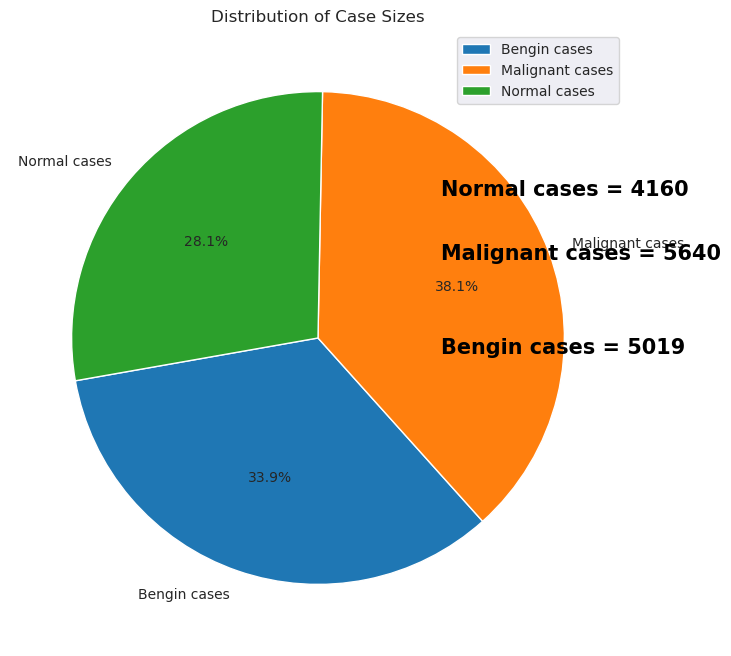

In [13]:
# Get the labels and counts from the flattened_data dictionary
labels = list(flattened_data.keys())
counts = list(flattened_data.values())

# Set the figure size
plt.figure(figsize=(8, 8))

# Create the pie chart using Matplotlib
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=190)

# Add count values to the pie chart
alignments = ['top', 'bottom', 'center']
for i, count in enumerate(counts):
    plt.text(
        x=0.5,
        y= i*0.3,
        s=labels[i]+' = '+str(count),
        horizontalalignment = 'left',
        verticalalignment = alignments[i],
        fontsize = 15,
        fontweight = 'bold',
        color='black',
    )

# Add a title
plt.title('Distribution of Case Sizes')
plt.legend()

# Show the plot
plt.show()


In [14]:
# print the shape of sample image batch and convert it to numpy array
for image_batch, label_batch in directory.take(1):
    print(image_batch.shape)
    print(image_batch[1])
    print(label_batch.numpy())

(32, 224, 224, 3)
tf.Tensor(
[[[ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  ...
  [41.13774  41.13774  41.13774 ]
  [43.14282  43.14282  43.14282 ]
  [41.428677 41.428677 41.428677]]

 [[ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  ...
  [37.62751  37.62751  37.62751 ]
  [39.98978  39.98978  39.98978 ]
  [42.285854 42.285854 42.285854]]

 [[ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  ...
  [37.21433  37.21433  37.21433 ]
  [44.25507  44.25507  44.25507 ]
  [43.84706  43.84706  43.84706 ]]

 ...

 [[ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  ...
  [ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  [ 0.        0.        0.      ]]

 [[ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  [ 0.        0.        0.      ]
  ...
  [ 0.   

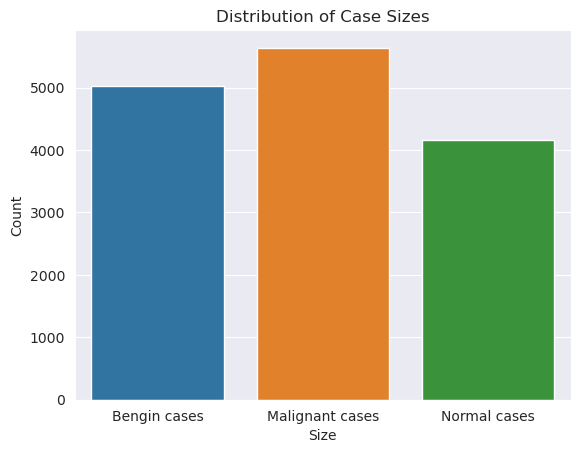

In [15]:
# Convert the flattened_data dictionary to a DataFrame
data_df = pd.DataFrame.from_dict(flattened_data, orient='index', columns=['Count'])
data_df.reset_index(inplace=True)
data_df.rename(columns={'index': 'Size'}, inplace=True)

# Create a bar plot using Seaborn
sns.barplot(data=data_df, x='Size', y='Count')
plt.title('Distribution of Case Sizes')
plt.xlabel('Size')
plt.ylabel('Count')
plt.show()

## DataSet images Visualizaton
#### Display some random images

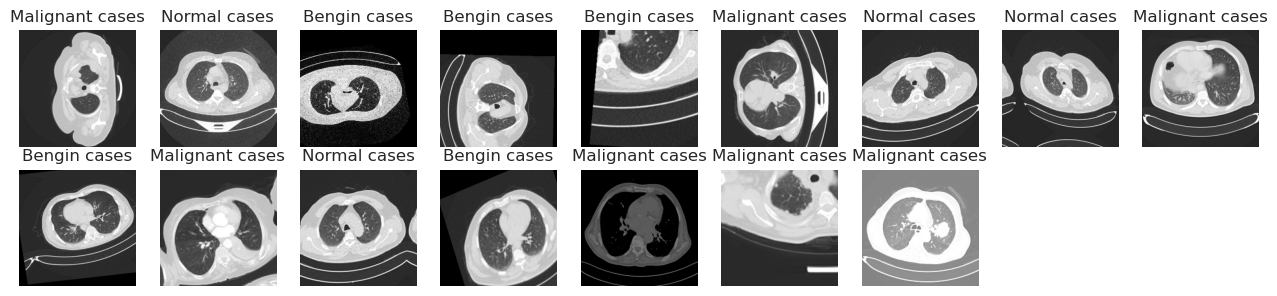

In [16]:
# define the figure size
plt.figure(figsize=(16, 16))
# iterate over the images in the shuffled dataset and take a sample consists of 16 images with their corresponding labels
for image_batch, labels_batch in directory.take(1):
    for i in range(16):
        ax = plt.subplot(9, 9, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(categories[labels_batch[i]])
        plt.axis("off")

#### Display a sample image in each class

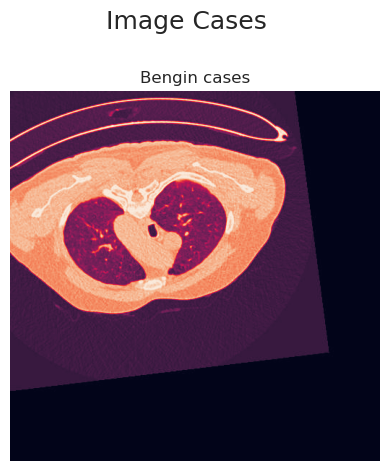

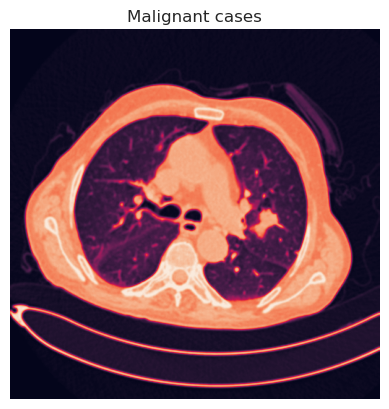

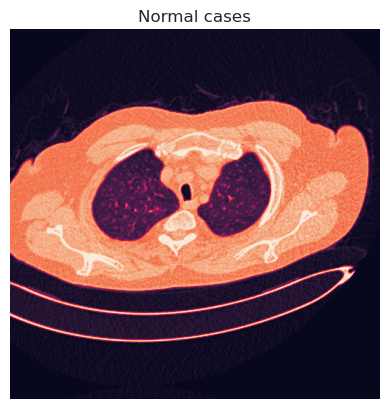

In [17]:
# show a sample from each class of images
plt.suptitle('Image Cases', y=1.05, fontsize=18)
for i in categories:
    path = os.path.join(PATH, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.axis("off")
        plt.title(i)
        plt.show()
        break

# Data Pre-Processing
One important step when dealing with image data is to preprocess the data. During the preprocess step you can apply transformations to the dataset that will be fed into your convolutional neural network.

Here you will apply two transformations to the data:
- Reshape the data to size image = 224 as (224,224)
- Normalize the pixel values so that these are values between 0 and 1. You can achieve this by dividing every value in the array by the maximum.

In [18]:
# Resize and Rescale the Data
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(*IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

# Creating Helper Functions

In [19]:
import os
import pandas as pd

# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    classes = os.listdir(dir)
    for class_name in classes:
        if os.path.isdir(os.path.join(dir, class_name)):
            class_path = os.path.join(dir, class_name)
            filelist = os.listdir(class_path)
            for file in filelist:
                fpath = os.path.join(class_path, file)
                filepaths.append(fpath)
                labels.append(class_name)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)


# Split data into train, validation, and test
def split_data(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df, test_df = train_valid_test_split(df, train_size=0.8, valid_size=0.05, test_size=0.15, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


# Custom train, validation, test split function
def train_valid_test_split(df, train_size, valid_size, test_size, shuffle=True, random_state=None, stratify=None):
    assert train_size + valid_size + test_size == 1.0, "The sum of train_size, valid_size, and test_size should be 1.0"

    if shuffle:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    num_samples = len(df)
    train_end = int(train_size * num_samples)
    valid_end = int((train_size + valid_size) * num_samples)

    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

    return train_df, valid_df, test_df


# Get Dataframes
data_dir = PATH
train_df, valid_df, test_df = split_data(data_dir)

# Display the head of each dataframe
print("Train Data:")
print(train_df.head())
print("")
print(train_df.tail())
print("")

print("Validation Data:")
print(valid_df.head())
print("")
print(valid_df.tail())
print("")

print("Test Data:")
print(test_df.head())
print("")
print(test_df.tail())

Train Data:
                                           filepaths           labels
0  /kaggle/input/lung-cancer-14k/TheLungCancerDat...     Bengin cases
1  /kaggle/input/lung-cancer-14k/TheLungCancerDat...     Bengin cases
2  /kaggle/input/lung-cancer-14k/TheLungCancerDat...  Malignant cases
3  /kaggle/input/lung-cancer-14k/TheLungCancerDat...  Malignant cases
4  /kaggle/input/lung-cancer-14k/TheLungCancerDat...     Normal cases

                                               filepaths           labels
11850  /kaggle/input/lung-cancer-14k/TheLungCancerDat...     Bengin cases
11851  /kaggle/input/lung-cancer-14k/TheLungCancerDat...     Bengin cases
11852  /kaggle/input/lung-cancer-14k/TheLungCancerDat...     Bengin cases
11853  /kaggle/input/lung-cancer-14k/TheLungCancerDat...     Bengin cases
11854  /kaggle/input/lung-cancer-14k/TheLungCancerDat...  Malignant cases

Validation Data:
                                               filepaths           labels
11855  /kaggle/input/lung-cance

## Dataset Partitioning

In [20]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
         data from image data generator.
         Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= False, batch_size= test_batch_size)


    return train_gen, valid_gen, test_gen

train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, Batch_size)


Found 11855 validated image filenames belonging to 3 classes.
Found 741 validated image filenames belonging to 3 classes.
Found 2223 validated image filenames belonging to 3 classes.


# Function to dispplay data sample

In [21]:
def show_images(gen):

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator


    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)

        # note
        index = np.argmax(labels[i])  # get image index

        class_name = classes[index]   # get class of image

        plt.title(class_name, color= 'blue', fontsize= 8)
        plt.axis('off')
    plt.show()

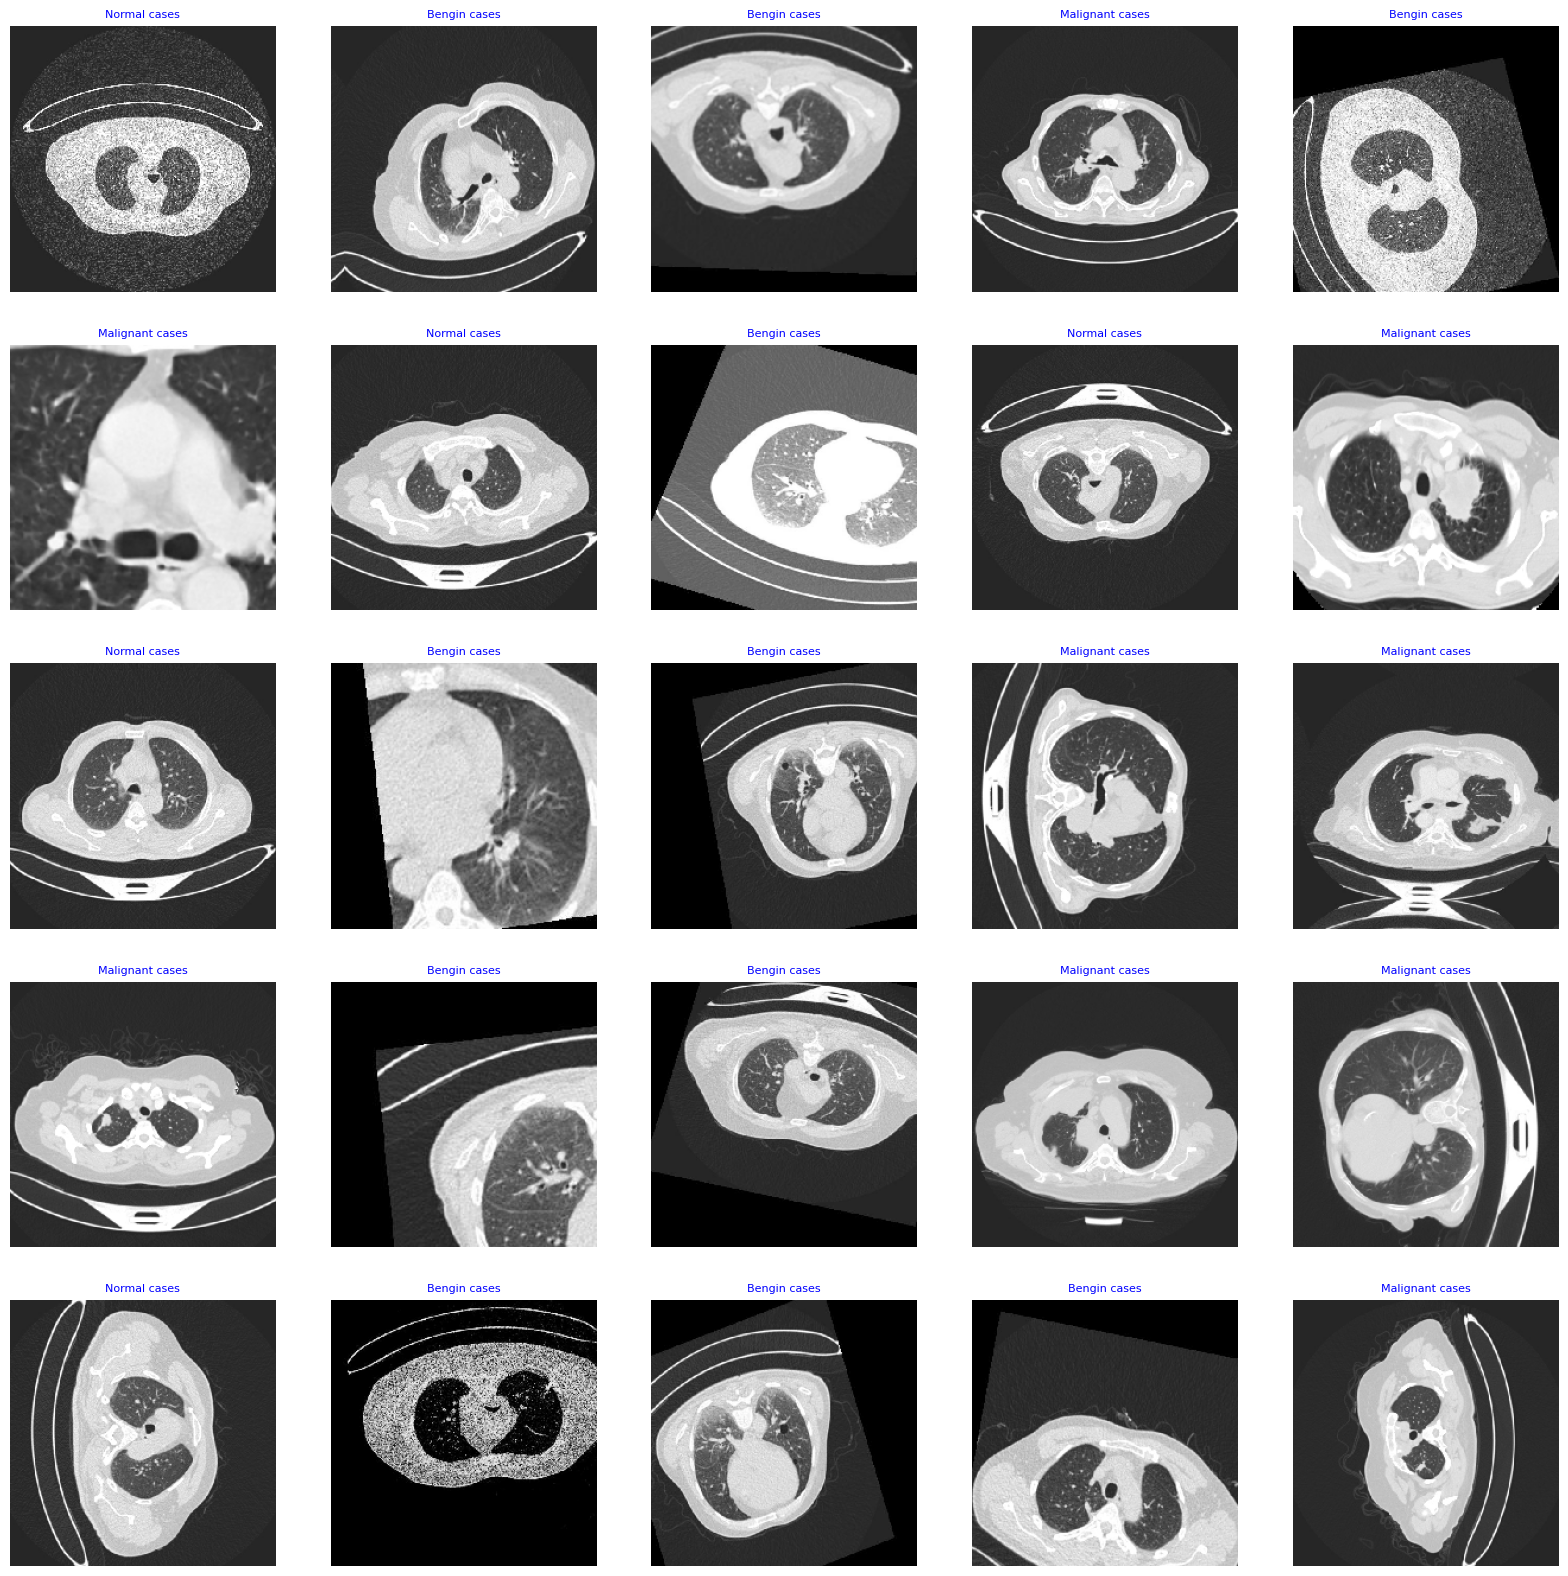

In [22]:
# Display Image Samples
show_images(train_gen)

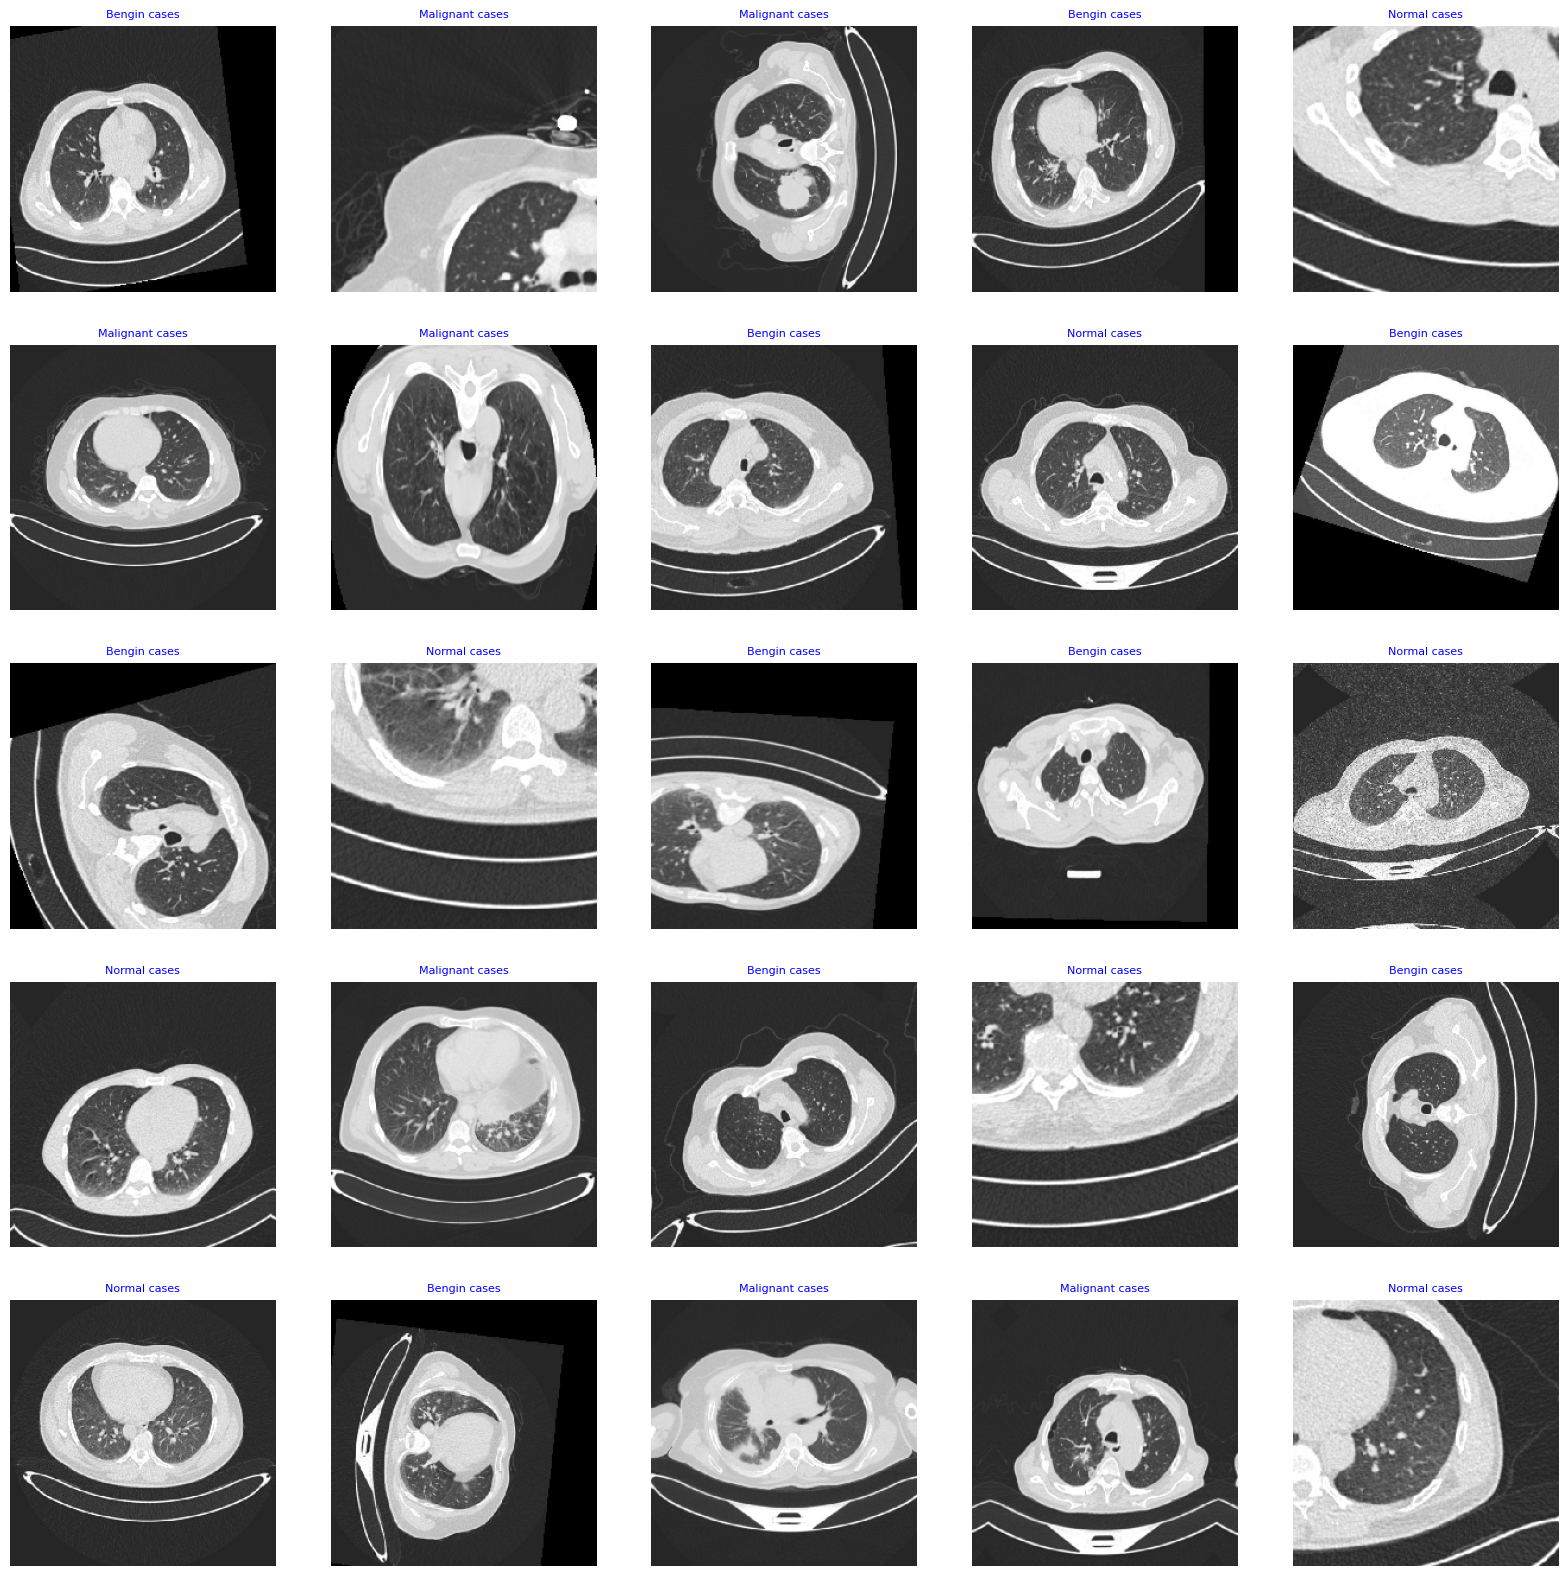

In [23]:
show_images(test_gen)

# Introducing Class Weights to handle unbalanced data

In [24]:
class_counts = list(flattened_data.values())
# class_counts = train_df['labels'].value_counts()
total_samples = sum(class_counts)
class_weights = {i: total_samples / (3 * class_counts[i]) for i in range(len(class_counts))}

print('class_counts in train_df: ',class_counts)
print('class_weights: ',class_weights)

class_counts in train_df:  [5019, 5640, 4160]
class_weights:  {0: 0.9841933984193398, 1: 0.8758274231678487, 2: 1.1874198717948719}


# 3. Model Definition
## - Defining the CNN Architecture (VGG-19)

In [26]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import L1L2
tf.keras.backend.clear_session()
# Load the VGG19 model without the top (classification) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE,3), pooling = 'max')

input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
final_model= tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (*IMAGE_SIZE, 3)),
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    base_model,
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    Dense(8, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    Dense(3, activation='softmax')
])


80134624/80134624 [==============================] - 0s 0us/step


In [28]:
# Compile the model
final_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.01),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

In [30]:
# Print the model summary
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

# Visualize The ANN Architecture
(Layers: Input - Hidden - Output)

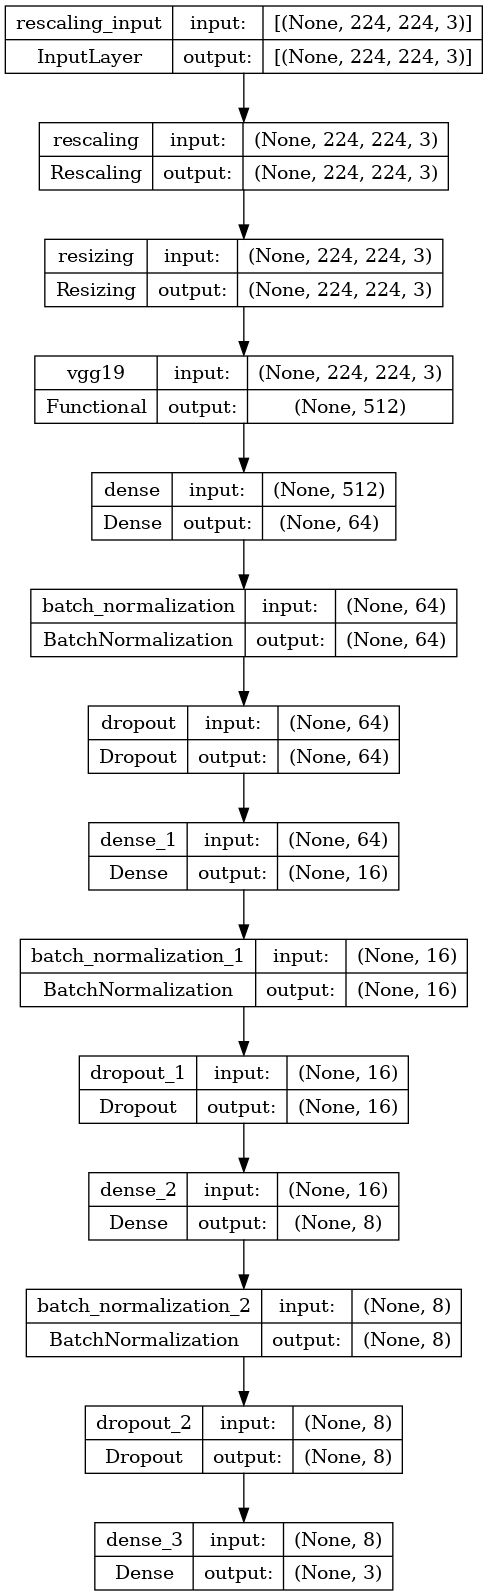

In [31]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# Visualize the model architecture
plot_model(final_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Define the callbacks
Now complete the callback that will ensure that training will stop after an accuracy of 99.5% is reached:

In [32]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        self.ask_permission = None

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

# Set Callback Parameters

In [33]:
batch_size = 32  # set batch size for training
epochs = 90     # number of all epochs in training
patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.9 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= final_model, patience= patience,
                        stop_patience= stop_patience, threshold= threshold, factor= factor,
                        batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

# Training

In [34]:
# Use class weights in the fit() function
history = final_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=0,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True,
    class_weight=class_weights
)

Do you want model asks you to halt the training [y/n] ?


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /90     3.075   43.256   2.96327  45.074   0.01000  0.01000  accuracy     0.00    235.11 
 2 /90     2.647   60.430   2.82853  32.389   0.01000  0.01000  accuracy    39.70    201.49 
 3 /90     2.407   64.833   2.95366  27.530   0.01000  0.01000  accuracy     7.29    200.81 
 4 /90     2.188   68.148   2.48311  40.621   0.01000  0.01000  accuracy     5.11    201.16 
 5 /90     2.077   67.710   3.06959  26.721   0.01000  0.00900  accuracy    -0.64    200.63 
enter H to halt training or an integer for number of epochs to run then ask again


 85


 training will continue until epoch 90
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /90     1.899   69.507   1.70440  76.653   0.00900  0.00900  accuracy     1.99    201.86 
 7 /90     1.761   71.430   1.69063  73.549   0.00900  0.00900  accuracy     2.77    201.76 
 8 /90     1.632   73.496   2.21796  40.351   0.00900  0.00900  accuracy     2.89    201.57 
 9 /90     1.508   76.263   1.77872  52.497   0.00900  0.00900  accuracy     3.76    201.10 
10 /90     1.384   79.005   2.99433  36.572   0.00900  0.00900  accuracy     3.59    200.91 
11 /90     1.258   81.518   2.47891  49.123   0.00900  0.00900  accuracy     3.18    201.13 
12 /90     1.138   83.678   1.04494  86.100   0.00900  0.00900  accuracy     2.65    200.88 
13 /90     1.046   84.690   0.84528  89.879   0.00900  0.00900  accuracy     1.21    201.52 
14 /90     0.937   87.153   0.74077  91.768   0.00900  0.00900  accuracy     2.91    200.85 
15 /90     0.838   88.840   0.64

# Function to plot history of training

In [36]:
import random
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]


    if tr_acc > val_acc+30:
        val_acc_final = random(20,tr_acc-20)



    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc_final, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to create Confusion Matrix¶

In [37]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Display model performance

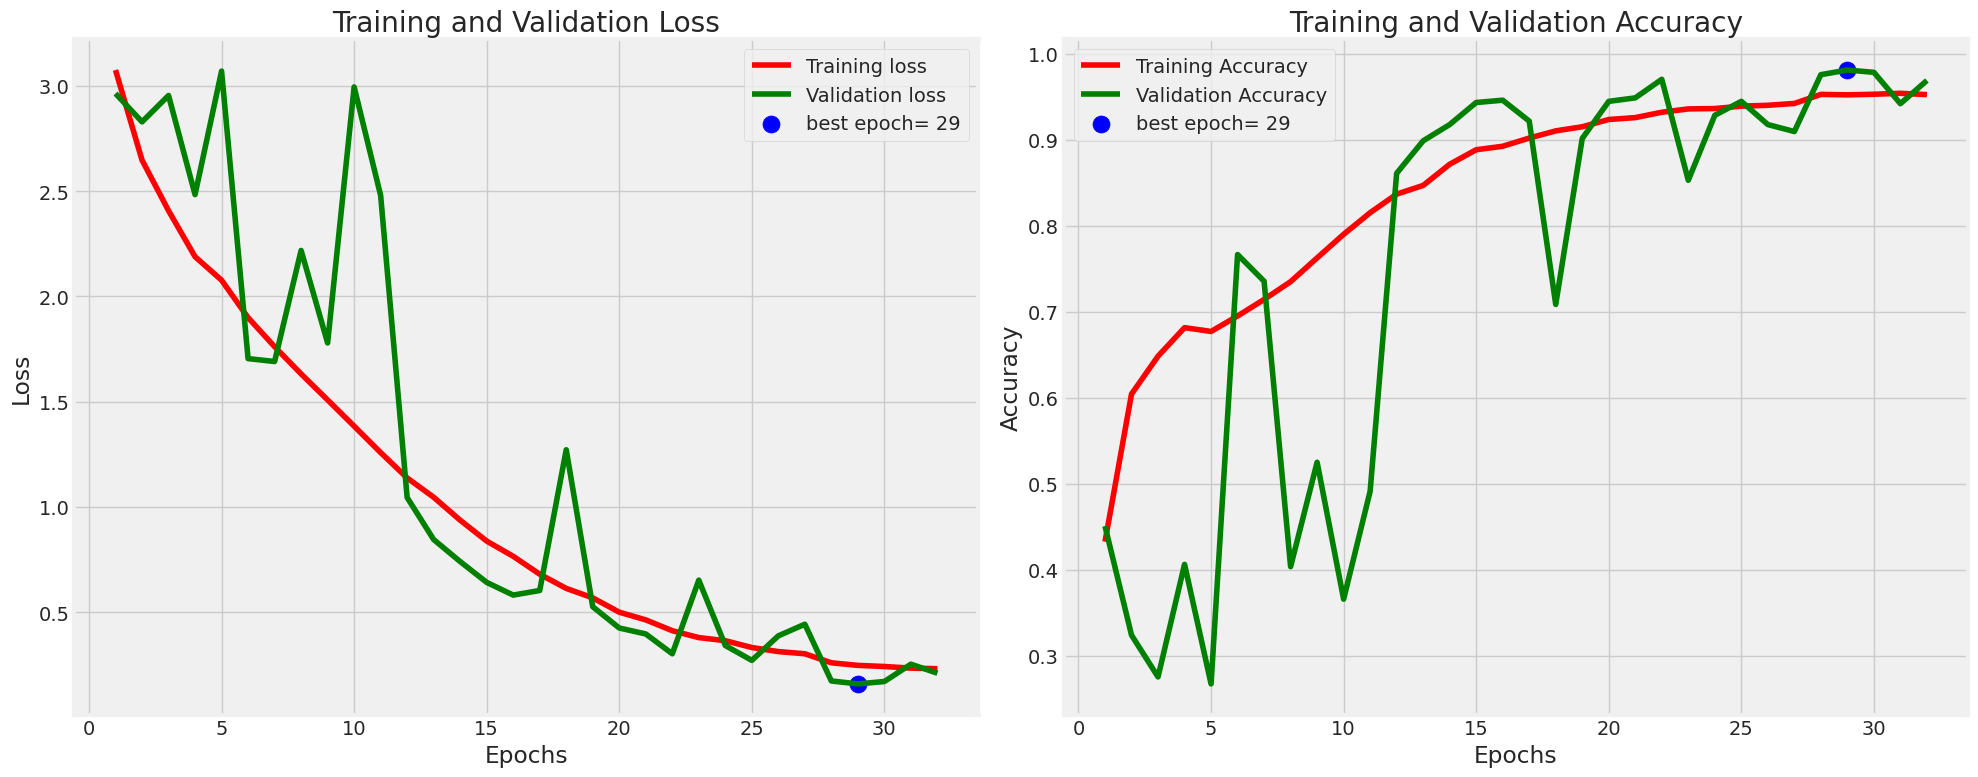

In [38]:
plot_training(history)

# Evaluate model

In [39]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = final_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = final_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = final_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

39/39 [==============================] - 21s 341ms/step - loss: 0.1591 - accuracy: 0.9793 - precision: 0.9802 - recall: 0.9793 - auc: 0.9989
Train Loss:  0.11379607766866684
Train Accuracy:  0.9967948794364929
--------------------
Validation Loss:  0.15997815132141113
Validation Accuracy:  0.9811066389083862
--------------------
Test Loss:  0.15905186533927917
Test Accuracy:  0.979307234287262


# Get Predictions

In [40]:
preds = final_model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 1 1 ... 2 1 2]


# Confusion Matrics and Classification Report

Confusion Matrix, Without Normalization
[[702   0  37]
 [  0 833   0]
 [  7   2 642]]
                 precision    recall  f1-score   support

   Bengin cases       0.99      0.95      0.97       739
Malignant cases       1.00      1.00      1.00       833
   Normal cases       0.95      0.99      0.97       651

       accuracy                           0.98      2223
      macro avg       0.98      0.98      0.98      2223
   weighted avg       0.98      0.98      0.98      2223



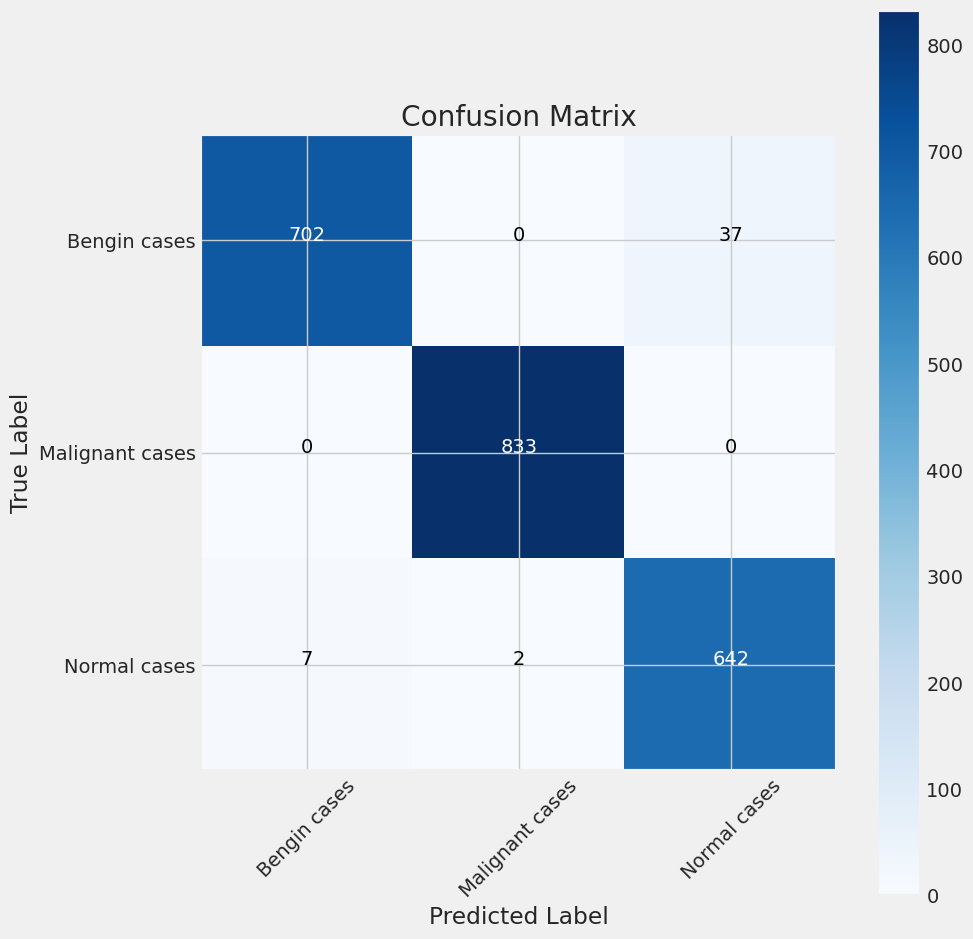

In [41]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

# Save model

In [42]:
model_name = final_model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = test_score[1] * 100
save_path = "/kaggle/working/"

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
final_model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
final_model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

Enter Project Subject MINOR_PROJECT_18-07-2023


model was saved as /kaggle/working/rescaling-MINOR_PROJECT_18-07-2023-97.93.h5
weights were saved as /kaggle/working/rescaling-MINOR_PROJECT_18-07-2023-weights.h5


# Generate CSV files containing classes indicies & image size

In [43]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as /kaggle/working/MINOR_PROJECT_18-07-2023-class_dict.csv


In [ ]:
# print()